In [83]:
import torchvision.datasets as datasets 
import matplotlib.pyplot as plt  
import numpy as np 
import time 
from sklearn.metrics import accuracy_score

In [39]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

train_images = train_dataset.data.float() /255.
train_labels = train_dataset.targets 

test_images = test_dataset.data.float() /255.
test_labels = test_dataset.targets 


In [40]:
train_images = train_images.numpy().reshape(train_images.shape[0],-1)
test_images = test_images.numpy().reshape(test_images.shape[0],-1)
new_train_labels = np.where(train_labels > 4, 1, 0)
new_test_labels = np.where(test_labels > 4, 1, 0) 

In [41]:
train_images.shape, test_images.shape, new_train_labels.shape, new_test_labels.shape

((60000, 784), (10000, 784), (60000,), (10000,))

##### **1. Apply the normalization on the training and test data.**

In [42]:
eps = 1e-6 # a small constant value for smoothing (to avoid divide by std value of 0) 
X_train = (train_images - np.mean(train_images, axis=0))/(np.std(train_images, axis=0) + eps)
X_test = (test_images - np.mean(test_images, axis=0))/(np.std(test_images, axis=0) + eps)


In [43]:
# add ones column 
X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1) 
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1) 

In [44]:
y_train = new_train_labels
y_test = new_test_labels 

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((60000, 785), (10000, 785), (60000,), (10000,))

##### **2. As a baseline, train a linear classifier $y = v^Tx$ and quadratic loss. Report its test accuracy.**

In [62]:
def linear_classifier(X, y, num_iters=10, learning_rate=0.5):
    weight = np.random.normal(0, 0.01, X_train.shape[1])
    n_samples, m = X.shape
    loss_arr = []
    
    for iter in range(num_iters):
        for i in range(n_samples): # calculate gradient and update weights for each image 
            pred = np.dot(X[i,:],weight)
            grad = X[i,:].T.dot((pred - y[i]))/n_samples
            weight -= learning_rate * grad    
        y_pred = np.dot(X, weight)
        loss = ((y_pred - y)**2).sum() / (2*n_samples) 
        loss_arr.append(loss)
        print(f"Epoch {iter+1} - Loss: {loss:.4f}")
    return weight

In [63]:
weight = linear_classifier(X_train,y_train)
ypred = X_train.dot(weight)
ypred = np.where(ypred > 0.5, 1, 0)

Epoch 1 - Loss: 0.1122
Epoch 2 - Loss: 0.0795
Epoch 3 - Loss: 0.0673
Epoch 4 - Loss: 0.0626
Epoch 5 - Loss: 0.0607
Epoch 6 - Loss: 0.0598
Epoch 7 - Loss: 0.0594
Epoch 8 - Loss: 0.0591
Epoch 9 - Loss: 0.0589
Epoch 10 - Loss: 0.0588


In [64]:
y_test_pred = X_test.dot(weight)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0) 

print(accuracy_score(y_test_pred, y_test))

0.862


##### **3. Train a neural network classifier with quadratic loss** 

**Loss Function and Derivatives of the loss function:**

$ \bar y = f(x) = v^T. Relu(W x) $ 

$ Loss, L = (\bar y - y)^2 $ 

$ \frac{dL}{dy} = 2(\bar y - y) $  

$ \frac{dL}{dv} = \frac{dL}{dy}. \frac{dy}{dv} = 2(\bar y - y). Relu(W.x^T) $  

$ \frac{dL}{dW} = \frac{dL}{dy}. \frac{dy}{dW} = 2(\bar y - y). (v. \frac{d}{dw}(Relu(Wx)) . x^T) $



In [84]:
class MyNeuralNet: 
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Xavier initialization with mean=0 and variance=1/n_in
        self.W = np.random.randn(self.hidden_size, self.input_size) * np.sqrt(1/self.input_size)
        self.v = np.random.randn(self.hidden_size) * np.sqrt(1/self.hidden_size)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def predict(self, x):
        return self.v.dot(self.relu(self.W.dot(x.T)))
    
    def get_grad(self, x, y):
        h = self.relu(self.W.dot(x.T))
        sigmap = self.W.dot(x.T)>0+0.
        yh = self.predict(x)
        r = yh - y
        grad_v = r * h
        grad_W = r * np.outer(self.v * sigmap, x.T)
        return grad_v, grad_W 
    
    def train(self, X_train, y_train, X_test, y_test, num_epochs=10, lr=0.01, batch_size=10):
        num_batches = X_train.shape[0] // batch_size
        train_acc = []
        test_acc = []

        for epoch in range(num_epochs):
            indices = [i for i in range(X_train.shape[0])]
            np.random.shuffle(indices)
            for i in range(num_batches):
                batch_indices = indices[i * batch_size: (i + 1) * batch_size]
                batch_X = X_train[batch_indices, :]
                batch_y = y_train[batch_indices]

                grad_v_sum = np.zeros(self.hidden_size)
                grad_W_sum = np.zeros((self.hidden_size, self.input_size)) 

                for x, y in zip(batch_X, batch_y):
                    grad_v, grad_W = self.get_grad(x, y)
                    grad_v_sum += grad_v
                    grad_W_sum += grad_W

                self.v -= lr * grad_v_sum / batch_size
                self.W -= lr * grad_W_sum / batch_size

                if (i==0 or (i+1) % 1000 == 0):
                    y_hat_test = (self.predict(X_test) > 0.5 + 0).astype(int)
                    y_hat_train = (self.predict(X_train) > 0.5 + 0).astype(int)
                    acc_tr = accuracy_score(y_hat_train, y_train)
                    acc_ts = accuracy_score(y_hat_test, y_test)
                    if i!=0:
                        train_acc.append(acc_tr)
                        test_acc.append(acc_ts)
                    print(f"{epoch+1}/{i+1}: train acc: {acc_tr:0.4f}, test acc: {acc_ts:0.4f}")

        return train_acc, test_acc
    
    

In [89]:
model1 = MyNeuralNet(785, 5, 1) 
tr_acc1, ts_acc1 = model1.train(X_train, y_train, X_test, y_test, lr=0.0001) 

1/1: train acc: 0.5356, test acc: 0.5317
1/1000: train acc: 0.5894, test acc: 0.5865
1/2000: train acc: 0.6365, test acc: 0.6342
1/3000: train acc: 0.6648, test acc: 0.6662
1/4000: train acc: 0.6861, test acc: 0.6854
1/5000: train acc: 0.7028, test acc: 0.6990
1/6000: train acc: 0.7154, test acc: 0.7122
2/1: train acc: 0.7154, test acc: 0.7124
2/1000: train acc: 0.7261, test acc: 0.7238
2/2000: train acc: 0.7361, test acc: 0.7352
2/3000: train acc: 0.7442, test acc: 0.7436
2/4000: train acc: 0.7515, test acc: 0.7494
2/5000: train acc: 0.7585, test acc: 0.7571
2/6000: train acc: 0.7643, test acc: 0.7624
3/1: train acc: 0.7643, test acc: 0.7624
3/1000: train acc: 0.7701, test acc: 0.7690
3/2000: train acc: 0.7766, test acc: 0.7759
3/3000: train acc: 0.7811, test acc: 0.7823
3/4000: train acc: 0.7862, test acc: 0.7880
3/5000: train acc: 0.7893, test acc: 0.7927
3/6000: train acc: 0.7927, test acc: 0.7966
4/1: train acc: 0.7928, test acc: 0.7966
4/1000: train acc: 0.7968, test acc: 0.8009


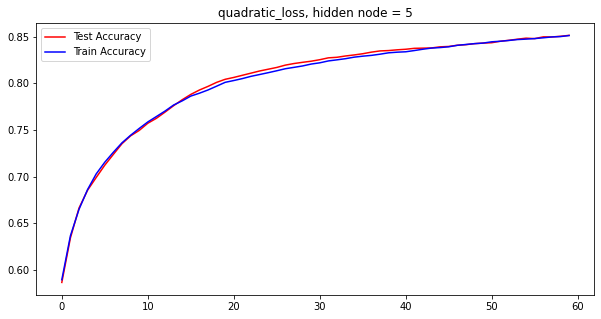

In [90]:
plt.figure(figsize=(10,5))
a = plt.subplot(111)
a.plot(ts_acc1,'r',label="Test Accuracy")
a.plot(tr_acc1, 'b',label="Train Accuracy")
plt.title("quadratic_loss, hidden node = 5")
a.legend()
plt.show() 

In [91]:
model2 = MyNeuralNet(785, 40, 1) 
tr_acc2, ts_acc2 = model2.train(X_train, y_train, X_test, y_test, lr=0.0001) 

1/1: train acc: 0.5108, test acc: 0.5123
1/1000: train acc: 0.5587, test acc: 0.5625
1/2000: train acc: 0.6162, test acc: 0.6278
1/3000: train acc: 0.6590, test acc: 0.6676
1/4000: train acc: 0.6925, test acc: 0.6993
1/5000: train acc: 0.7153, test acc: 0.7200
1/6000: train acc: 0.7324, test acc: 0.7383
2/1: train acc: 0.7325, test acc: 0.7383
2/1000: train acc: 0.7482, test acc: 0.7531
2/2000: train acc: 0.7597, test acc: 0.7660
2/3000: train acc: 0.7692, test acc: 0.7761
2/4000: train acc: 0.7774, test acc: 0.7823
2/5000: train acc: 0.7846, test acc: 0.7902
2/6000: train acc: 0.7915, test acc: 0.7968
3/1: train acc: 0.7916, test acc: 0.7967
3/1000: train acc: 0.7964, test acc: 0.8009
3/2000: train acc: 0.8021, test acc: 0.8057
3/3000: train acc: 0.8078, test acc: 0.8111
3/4000: train acc: 0.8115, test acc: 0.8156
3/5000: train acc: 0.8158, test acc: 0.8187
3/6000: train acc: 0.8199, test acc: 0.8213
4/1: train acc: 0.8199, test acc: 0.8212
4/1000: train acc: 0.8234, test acc: 0.8249


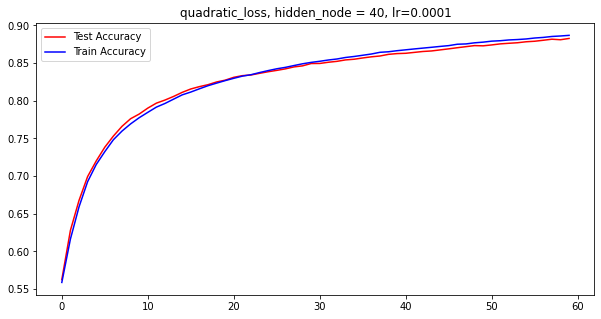

In [92]:
plt.figure(figsize=(10,5))
a = plt.subplot(111)
a.plot(ts_acc2,'r',label="Test Accuracy")
a.plot(tr_acc2, 'b',label="Train Accuracy")
plt.title("quadratic_loss, hidden_node = 40, lr=0.0001")
a.legend()
plt.show() 

In [93]:
model3 = MyNeuralNet(785, 200, 1) 
tr_acc3, ts_acc3 = model3.train(X_train, y_train, X_test, y_test, lr=0.0001) 

1/1: train acc: 0.5118, test acc: 0.5133
1/1000: train acc: 0.5986, test acc: 0.6084
1/2000: train acc: 0.6558, test acc: 0.6592
1/3000: train acc: 0.6974, test acc: 0.6993
1/4000: train acc: 0.7203, test acc: 0.7222
1/5000: train acc: 0.7358, test acc: 0.7377
1/6000: train acc: 0.7534, test acc: 0.7580
2/1: train acc: 0.7535, test acc: 0.7581
2/1000: train acc: 0.7643, test acc: 0.7676
2/2000: train acc: 0.7773, test acc: 0.7797
2/3000: train acc: 0.7855, test acc: 0.7866
2/4000: train acc: 0.7928, test acc: 0.7955
2/5000: train acc: 0.7970, test acc: 0.7976
2/6000: train acc: 0.8062, test acc: 0.8065
3/1: train acc: 0.8062, test acc: 0.8066
3/1000: train acc: 0.8131, test acc: 0.8130
3/2000: train acc: 0.8171, test acc: 0.8172
3/3000: train acc: 0.8225, test acc: 0.8231
3/4000: train acc: 0.8264, test acc: 0.8293
3/5000: train acc: 0.8291, test acc: 0.8313
3/6000: train acc: 0.8338, test acc: 0.8361
4/1: train acc: 0.8337, test acc: 0.8360
4/1000: train acc: 0.8375, test acc: 0.8386


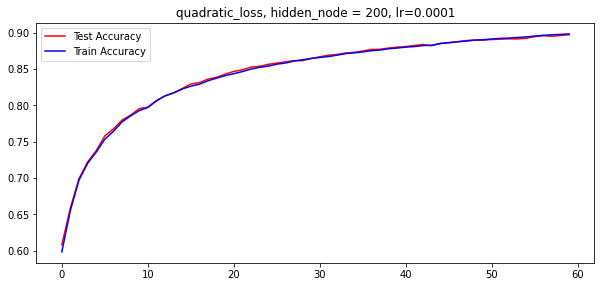

In [95]:
plt.figure(figsize=(10,15))
a = plt.subplot(311)
a.plot(ts_acc3,'r',label="Test Accuracy")
a.plot(tr_acc3, 'b',label="Train Accuracy")
a.set_title("quadratic_loss, hidden_node = 200, lr=0.0001")
a.legend()
plt.show()  

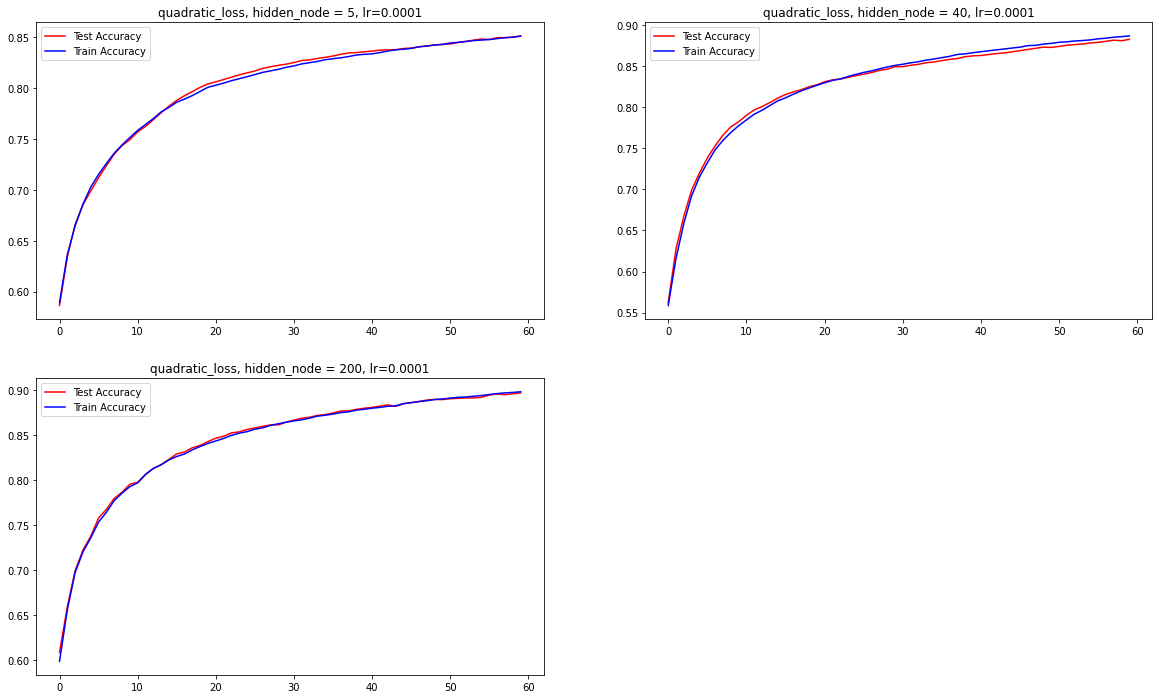

In [96]:
plt.figure(figsize=(20,12))
a = plt.subplot(221)
a.plot(ts_acc1,'r',label="Test Accuracy")
a.plot(tr_acc1, 'b',label="Train Accuracy")
a.set_title("quadratic_loss, hidden_node = 5, lr=0.0001")
a.legend() 

b = plt.subplot(222)
b.plot(ts_acc2,'r',label="Test Accuracy")
b.plot(tr_acc2, 'b',label="Train Accuracy")
b.set_title("quadratic_loss, hidden_node = 40, lr=0.0001")
b.legend() 

c = plt.subplot(223)
c.plot(ts_acc3,'r',label="Test Accuracy")
c.plot(tr_acc3, 'b',label="Train Accuracy")
c.set_title("quadratic_loss, hidden_node = 200, lr=0.0001")
c.legend()

plt.show() 

**Comment on the role of hidden units k on the ease of optimization and accuracy.** 

Final Test Accuracy: (Learning Rate = 0.0001)

- k=5:   0.8513 
- k=40:  0.8827 
- k=200: 0.8971 

Comments: 

- For accuracy, increasing hidden units is increasing the test accuracy.  

-  For optimization, we can see that, when hidden units are increased, parameters are optimized faster. 


##### **4. Train a neural network classifier with logistic loss**

$ \bar y = f(x) = v^T. Relu(W x) $

Loss, $L(y, \hat y) = -y log(\hat y) - (1-y)log(1-\hat y) $     where, $\hat y = \sigma(\bar y) = \frac{1}{1 + e^{\bar y}} $ 

Derivatives:  

$\frac{dL}{d\hat y} = \frac{-y}{\hat y} + \frac{1-y}{1-\hat y} $ 

$ \frac{d\hat y}{dv}  = \sigma(\hat y)(1-\sigma(\hat y)) h,  [ let, f(x)= v^T. h]$ 

**Therefore,** $\frac{dL}{dv} = \frac{dL}{d\hat y} * \frac{d\hat y}{dv}$ 

$ \frac{d\hat y}{dh} =  \frac{d}{dh} (\sigma(v^T.h)) = \sigma(v^T.h) .(1-\sigma(v^T.h)). v $ 

$ \frac{dh}{dz} = $ 1 if z>0, 0 otherwise,[ h = Relu(z), z = Wx ] 

$ \frac{dz}{dW} = \frac{d}{dW} (W.x) = x $ 

**Therefore,** $\frac{dL}{dW} = \frac{dL}{d\hat y} * \frac{d\hat y}{dh} * \frac{dh}{dz} * \frac{dz}{dW}$ 

In [74]:
import numpy as np
from sklearn.metrics import accuracy_score

class MyNeuralNet2: 
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W = np.random.randn(self.hidden_size, self.input_size) * np.sqrt(1/self.input_size)
        self.v = np.random.randn(self.hidden_size) * np.sqrt(1/self.hidden_size)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x)) 
    
    def predict(self, x):
        return self.sigmoid(self.v.dot(self.relu(self.W.dot(x.T))))
    
   
    def get_grad(self, x, y):
        z = np.dot(self.W, x)
        h = self.relu(z)
        y_hat = self.sigmoid(np.dot(self.v, h))

        dL_dy_hat = - y / y_hat + (1 - y) / (1 - y_hat)
        dy_hat_dv = h * y_hat * (1 - y_hat)
        dL_dv = dL_dy_hat * dy_hat_dv 

        dz_dW = x[:, np.newaxis]
        dh_dz = (z > 0).astype(float)
        dy_hat_dh = self.v * y_hat * (1 - y_hat) 
        dL_dW = dL_dy_hat * np.outer(dy_hat_dh * dh_dz, dz_dW)
        dL_dW = np.mean(dL_dW, axis=0)

        return dL_dv, dL_dW
    
    def train(self, X_train, y_train, X_test, y_test, num_epochs=10, lr=0.01, batch_size=10):
        num_batches = X_train.shape[0] // batch_size
        train_acc = []
        test_acc = []

        for epoch in range(num_epochs):
            indices = [i for i in range(X_train.shape[0])]
            np.random.shuffle(indices)
            for i in range(num_batches):
                batch_indices = indices[i * batch_size: (i + 1) * batch_size]
                batch_X = X_train[batch_indices, :]
                batch_y = y_train[batch_indices]

                grad_v_sum = np.zeros(self.hidden_size)
                grad_W_sum = np.zeros((self.hidden_size, self.input_size)) 

                for x, y in zip(batch_X, batch_y):
                    grad_v, grad_W = self.get_grad(x, y)
                    grad_v_sum += grad_v
                    grad_W_sum += grad_W

                self.v -= lr * grad_v_sum / batch_size
                self.W -= lr * grad_W_sum / batch_size

                if (i==0 or (i+1) % 1000 == 0):
                    y_hat_test = (self.predict(X_test) > 0.5 + 0).astype(int)
                    y_hat_train = (self.predict(X_train) > 0.5 + 0).astype(int)
                    acc_tr = accuracy_score(y_hat_train, y_train) 
                    acc_ts = accuracy_score(y_hat_test, y_test)
                    if i!=0:
                        train_acc.append(acc_tr)
                        test_acc.append(acc_ts)
                    print(f"{epoch+1}/{i+1}: train acc: {acc_tr:0.4f}, test acc: {acc_ts:0.4f}")

        return train_acc, test_acc
    
    

In [75]:
model21 = MyNeuralNet2(785, 5, 1) 
tr_acc21, ts_acc21 = model21.train(X_train, y_train, X_test, y_test, lr=0.0001)  

1/1: train acc: 0.4620, test acc: 0.4683
1/1000: train acc: 0.4643, test acc: 0.4704
1/2000: train acc: 0.4667, test acc: 0.4732
1/3000: train acc: 0.4697, test acc: 0.4776
1/4000: train acc: 0.4723, test acc: 0.4796
1/5000: train acc: 0.4761, test acc: 0.4817
1/6000: train acc: 0.4788, test acc: 0.4851
2/1: train acc: 0.4788, test acc: 0.4852
2/1000: train acc: 0.4828, test acc: 0.4911
2/2000: train acc: 0.4874, test acc: 0.4942
2/3000: train acc: 0.4919, test acc: 0.4984
2/4000: train acc: 0.4971, test acc: 0.5034
2/5000: train acc: 0.5023, test acc: 0.5076
2/6000: train acc: 0.5080, test acc: 0.5146
3/1: train acc: 0.5080, test acc: 0.5146
3/1000: train acc: 0.5138, test acc: 0.5213
3/2000: train acc: 0.5210, test acc: 0.5290
3/3000: train acc: 0.5288, test acc: 0.5381
3/4000: train acc: 0.5361, test acc: 0.5457
3/5000: train acc: 0.5443, test acc: 0.5553
3/6000: train acc: 0.5529, test acc: 0.5646
4/1: train acc: 0.5529, test acc: 0.5646
4/1000: train acc: 0.5642, test acc: 0.5768


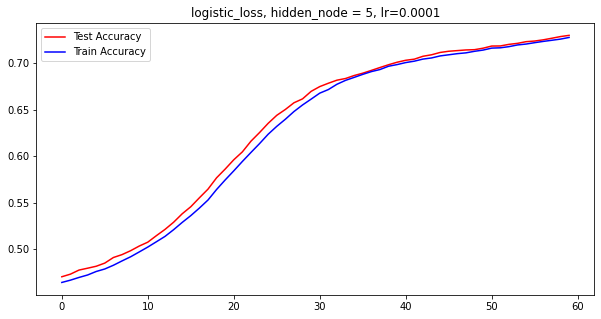

In [76]:
plt.figure(figsize=(10,5))
plt.plot(ts_acc21,'r',label="Test Accuracy")
plt.plot(tr_acc21, 'b',label="Train Accuracy")
plt.title("logistic_loss, hidden_node = 5, lr=0.0001")
plt.legend()
plt.show() 

In [77]:
model22 = MyNeuralNet2(785, 40, 1) 
tr_acc22, ts_acc22 = model22.train(X_train, y_train, X_test, y_test, lr=0.0001) 

1/1: train acc: 0.5509, test acc: 0.5543
1/1000: train acc: 0.5553, test acc: 0.5580
1/2000: train acc: 0.5601, test acc: 0.5627
1/3000: train acc: 0.5649, test acc: 0.5687
1/4000: train acc: 0.5690, test acc: 0.5736
1/5000: train acc: 0.5740, test acc: 0.5795
1/6000: train acc: 0.5779, test acc: 0.5831
2/1: train acc: 0.5779, test acc: 0.5830
2/1000: train acc: 0.5810, test acc: 0.5872
2/2000: train acc: 0.5839, test acc: 0.5901
2/3000: train acc: 0.5883, test acc: 0.5932
2/4000: train acc: 0.5910, test acc: 0.5961
2/5000: train acc: 0.5943, test acc: 0.5988
2/6000: train acc: 0.5969, test acc: 0.6020
3/1: train acc: 0.5970, test acc: 0.6020
3/1000: train acc: 0.6001, test acc: 0.6060
3/2000: train acc: 0.6028, test acc: 0.6083
3/3000: train acc: 0.6057, test acc: 0.6107
3/4000: train acc: 0.6085, test acc: 0.6136
3/5000: train acc: 0.6106, test acc: 0.6173
3/6000: train acc: 0.6133, test acc: 0.6207
4/1: train acc: 0.6133, test acc: 0.6207
4/1000: train acc: 0.6163, test acc: 0.6240


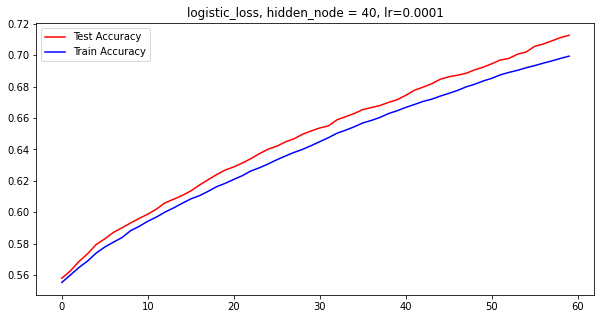

In [78]:
plt.figure(figsize=(10,5))
plt.plot(ts_acc22,'r',label="Test Accuracy")
plt.plot(tr_acc22, 'b',label="Train Accuracy")
plt.title("logistic_loss, hidden_node = 40, lr=0.0001")
plt.legend()
plt.show() 

In [79]:
model23 = MyNeuralNet2(785, 200, 1) 
tr_acc23, ts_acc23 = model23.train(X_train, y_train, X_test, y_test, lr=0.0001)  

1/1: train acc: 0.4725, test acc: 0.4682
1/1000: train acc: 0.5068, test acc: 0.4999
1/2000: train acc: 0.5432, test acc: 0.5397
1/3000: train acc: 0.5740, test acc: 0.5704
1/4000: train acc: 0.6013, test acc: 0.6040
1/5000: train acc: 0.6266, test acc: 0.6287
1/6000: train acc: 0.6486, test acc: 0.6499
2/1: train acc: 0.6488, test acc: 0.6500
2/1000: train acc: 0.6672, test acc: 0.6703
2/2000: train acc: 0.6819, test acc: 0.6873
2/3000: train acc: 0.6957, test acc: 0.7031
2/4000: train acc: 0.7093, test acc: 0.7165
2/5000: train acc: 0.7188, test acc: 0.7266
2/6000: train acc: 0.7267, test acc: 0.7358
3/1: train acc: 0.7267, test acc: 0.7358
3/1000: train acc: 0.7336, test acc: 0.7438
3/2000: train acc: 0.7397, test acc: 0.7502
3/3000: train acc: 0.7452, test acc: 0.7573
3/4000: train acc: 0.7503, test acc: 0.7615
3/5000: train acc: 0.7542, test acc: 0.7649
3/6000: train acc: 0.7578, test acc: 0.7680
4/1: train acc: 0.7579, test acc: 0.7678
4/1000: train acc: 0.7605, test acc: 0.7702


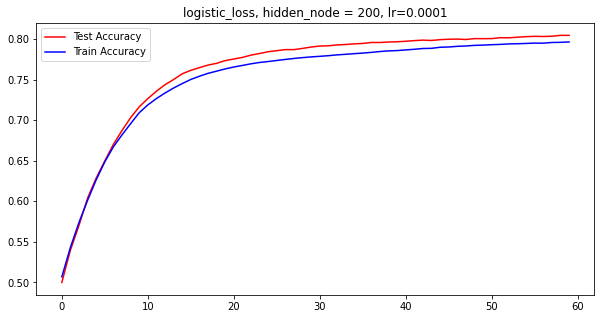

In [80]:
plt.figure(figsize=(10,5))
plt.plot(ts_acc23,'r',label="Test Accuracy")
plt.plot(tr_acc23, 'b',label="Train Accuracy")
plt.title("logistic_loss, hidden_node = 200, lr=0.0001")
plt.legend()
plt.show() 

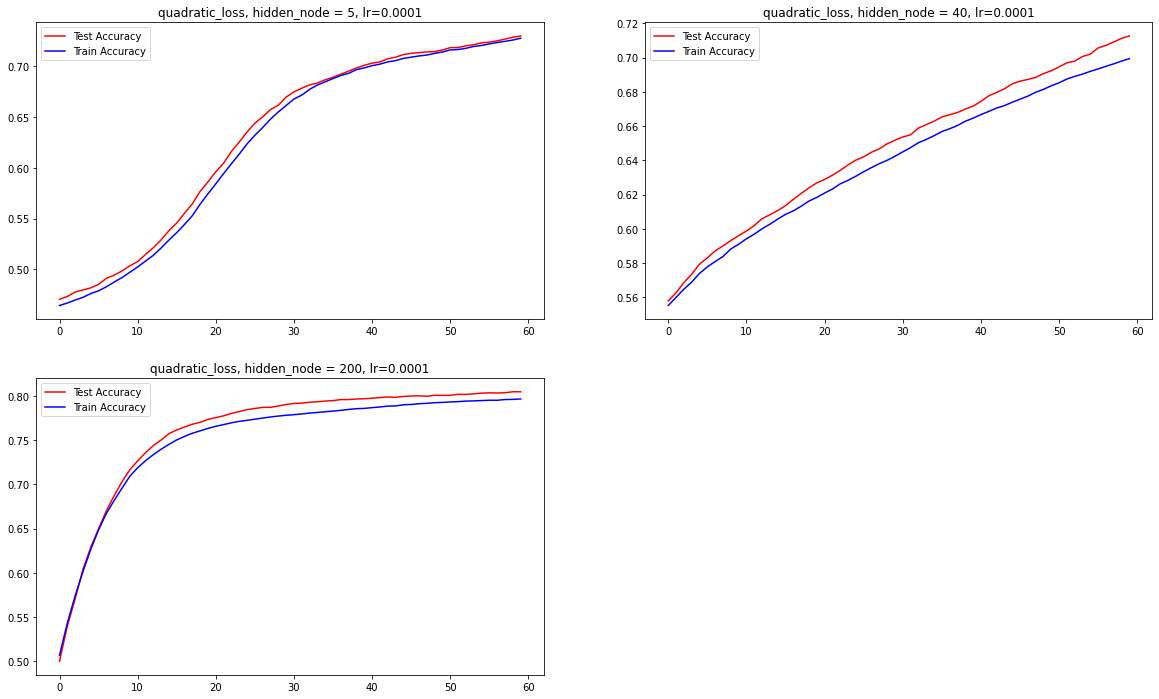

In [81]:
plt.figure(figsize=(20,12))
a = plt.subplot(221)
a.plot(ts_acc21,'r',label="Test Accuracy")
a.plot(tr_acc21, 'b',label="Train Accuracy")
a.set_title("quadratic_loss, hidden_node = 5, lr=0.0001")
a.legend() 

b = plt.subplot(222)
b.plot(ts_acc22,'r',label="Test Accuracy")
b.plot(tr_acc22, 'b',label="Train Accuracy")
b.set_title("quadratic_loss, hidden_node = 40, lr=0.0001")
b.legend() 

c = plt.subplot(223)
c.plot(ts_acc23,'r',label="Test Accuracy")
c.plot(tr_acc23, 'b',label="Train Accuracy")
c.set_title("quadratic_loss, hidden_node = 200, lr=0.0001")
c.legend()

plt.show() 

**Comment on the role of hidden units k on the ease of optimization and accuracy.** 

Final Test Accuracy: (Learning Rate = 0.0001)

- k=5:   0.7300 
- k=40:  0.7127
- k=200: 0.8047  

Comments: 

- For accuracy, increasing hidden units is increasing the test accuracy. 

-  For optimization, we can see that, when hidden units are increased, parameters are optimized faster. 

##### **5. Comment** 

a) Comment on the difference between linear model and neural net. 

b)Comment on the differences between logistic and quadratic loss in terms of optimization and test/train accuracy.

a) Linear model accuracy is 0.862. Neural net test accuracy is more. for quadratic loss we get 0.8971 within 10 epoch. So, Neural Network seems to perform this classification task better. 

b) If we compare quadratic loss and logistic loss, we can see that quadratic loss function seems to optimize the parameter faster than logistic loss. Although, logistic loss function can further optimize the parameters if we continue for more iterations. For instance, when k=200, within first 10000 minibatch, test accuracy becomes more than 0.8 for quadratic loss, but it is slightly more than 0.7 for logistic loss. 